# B) REGRESSION /MACHINE LEARNING

In this project, we will analyze the *data_B* data and create a model that predicts labor force participation (_inlf_ variable). 

Here are the steps we will be following:

        I. Import and explore the data

        II. Prepare the data

        III. Build the model

#### Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import Series

import math
from math import sqrt
from scipy import stats


import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose as sd

from sklearn.model_selection import train_test_split 
from sklearn import metrics, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.feature_selection import RFE

import warnings                                  
warnings.filterwarnings('ignore')

%matplotlib inline

## I. Import and explore the data

### 1. Import and describe data:

In [3]:
data_B = pd.read_csv('data_B.csv')
print(data_B.head(5))
print(data_B.shape)

   inlf  hours  kidslt6  kidsge6  age  educ    wage  repwage  hushrs  husage  \
0     1   1610        1        0   32    12  3.3540     2.65    2708      34   
1     1   1656        0        2   30    12  1.3889     2.65    2310      30   
2     1   1980        1        3   35    12  4.5455     4.04    3072      40   
3     1    456        0        3   34    12  1.0965     3.25    1920      53   
4     1   1568        1        2   31    14  4.5918     3.60    2000      32   

    ...     faminc     mtr  motheduc  fatheduc  unem  city  exper   nwifeinc  \
0   ...      16310  0.7215        12         7   5.0     0     14  10.910060   
1   ...      21800  0.6615         7         7  11.0     1      5  19.499981   
2   ...      21040  0.6915        12         7   5.0     0     15  12.039910   
3   ...       7300  0.7815         7         7   5.0     0      6   6.799996   
4   ...      27300  0.6215        12        14   9.5     1      7  20.100060   

      lwage  expersq  
0  1.210154    

We have 753 rows of data, 21 input variables and one variable we want to predict: __inlf__ .

### 2. Inspect data quality and missing values

In [4]:
missing_data_B=data_B.isnull().sum().reset_index(name='Missing Values')
missing_data_B[missing_data_B["Missing Values"] > 0]

,index,Missing Values
6,wage,325
20,lwage,325


It looks like all the data is there, except for 2 variables: wage and lwage. This is not surprising since women who did not participate in labor didn't have a wage. We will replace missing values in these two variables with 0.

In [5]:
data_B1=data_B.fillna(0)
data_B1["wage"].describe()

count    753.000000
mean       2.374565
std        3.241829
min        0.000000
25%        0.000000
50%        1.625000
75%        3.787900
max       25.000000
Name: wage, dtype: float64

In [6]:
data_B1.describe().loc[["min","mean","max"],:]

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
min,0.000000,0.000000,0.000000,0.000000,30.000000,5.000000,0.000000,0.000000,175.000000,30.00000,...,1500.000000,0.441500,0.000000,0.000000,3.000000,0.000000,0.00000,-0.029058,-2.054164,0.000000
mean,0.568393,740.576361,0.237716,1.353254,42.537849,12.286853,2.374565,1.849734,2267.270916,45.12085,...,23080.594954,0.678863,9.250996,8.808765,8.623506,0.642762,10.63081,20.128964,0.676486,178.038513
max,1.000000,4950.000000,3.000000,8.000000,60.000000,17.000000,25.000000,9.980000,5010.000000,60.00000,...,96000.000000,0.941500,17.000000,17.000000,14.000000,1.000000,45.00000,96.000000,3.218876,2025.000000


### 3. Visualize the data

We will plot a few of the variables.

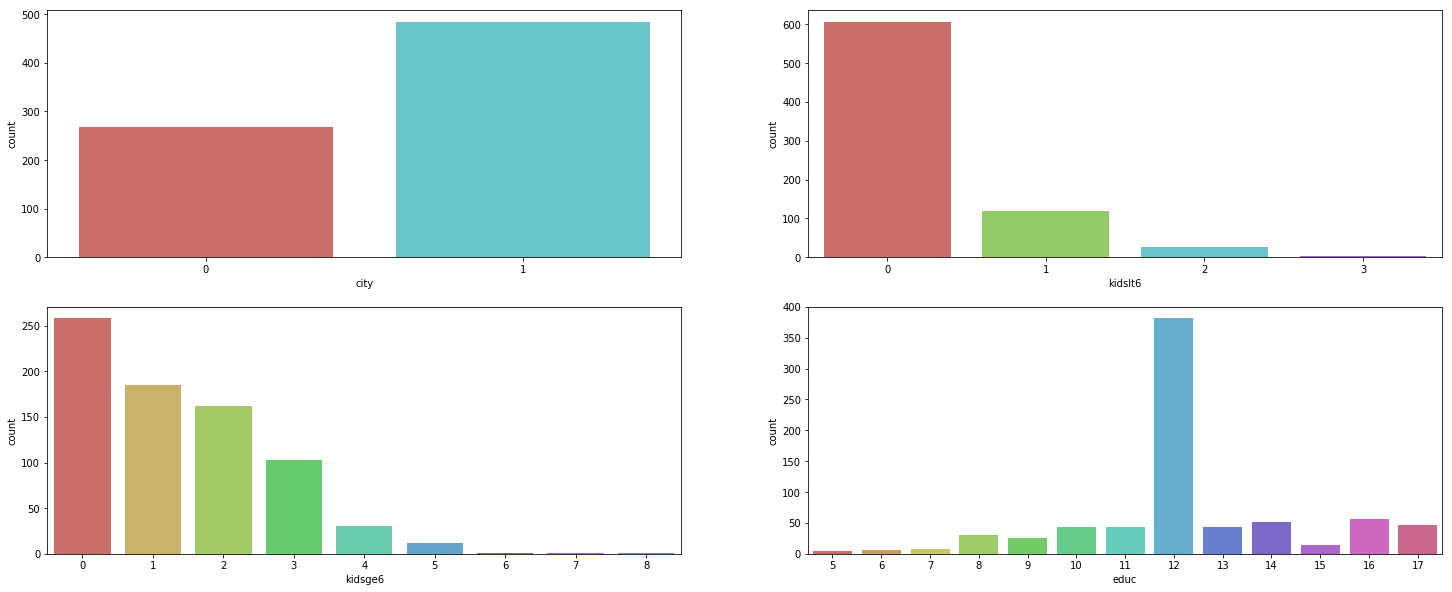

In [7]:
plt.rcParams['figure.figsize'] = [25, 10]
plt.subplot(2, 2, 1)
sns.countplot(x='city',data=data_B1, palette='hls')
plt.subplot(2,2,2)
sns.countplot(x='kidslt6',data=data_B1,palette='hls')
plt.subplot(2,2,3)
sns.countplot(x='kidsge6',data=data_B1,palette='hls')
plt.subplot(2,2,4)
sns.countplot(x='educ',data=data_B1,palette='hls')
plt.show()

## II. Prepare the data

It is a supervised problem, because the data set contains examples of expected outcomes, and it is a classification type problem because outcomes are binary.

Because of the nature of the variable we want to predict, we will perform a __Binary logistic regression__ model.
We will make sure to respect the algorithm's major requirement:

1) The dependent variable should be binary.

2) There should be no outliers in the data.

3) There should be little or no multicollinearity among the independent variables.


### 1) Prepare the variable to predict 

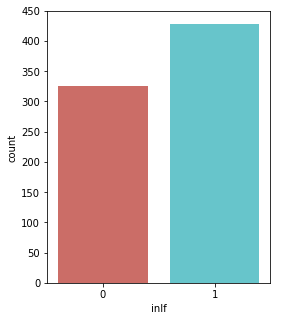

1    428
0    325
Name: inlf, dtype: int64


In [8]:
plt.rcParams['figure.figsize'] = [4, 5]

sns.countplot(x='inlf',data=data_B1, palette='hls')
plt.show()

print(data_B1["inlf"].value_counts())

The _inlf_ variable is binary: it has only 2 possible values: 0 or 1. It is 1 if a woman worked for a wage during 1975, and 0 if not. The mean of the participation variable inlf is 0.568 which means 56.8% of women included in the sample were in the labor force.

In [9]:
data_B1.groupby("inlf").aggregate(["min","mean","max"]).stack()

hours   kidslt6   kidsge6        age       educ       wage  \
inlf                                                                          
0    min      0.000000  0.000000  0.000000  30.000000   5.000000   0.000000   
     mean     0.000000  0.366154  1.356923  43.283077  11.796923   0.000000   
     max      0.000000  3.000000  7.000000  60.000000  17.000000   0.000000   
1    min     12.000000  0.000000  0.000000  30.000000   5.000000   0.128200   
     mean  1302.929907  0.140187  1.350467  41.971963  12.658879   4.177682   
     max   4950.000000  2.000000  8.000000  60.000000  17.000000  25.000000   

            repwage       hushrs     husage    huseduc     ...       \
inlf                                                       ...        
0    min   0.000000   640.000000  30.000000   3.000000     ...        
     mean  0.090154  2311.790769  45.793846  12.332308     ...        
     max   4.800000  4640.000000  60.000000  17.000000     ...        
1    min   0.000000   175.000000  30.000000   4.000000     ...        
     mean  3.185864  2233.464953  44.609813  12.612150     ...        
     max   9.980000  5010.000000  60.000000  17.000000     ...        

                 faminc       mtr   motheduc   fatheduc       unem      city  \
inlf                                                                           
0    min    1500.000000  0.441500   0.000000   0.000000   3.000000  0.000000   
     mean  21698.052308  0.692731   8.901538   8.572308   8.726154  0.646154   
     max   96000.000000  0.941500  17.000000  17.000000  14.000000  1.000000   
1    min    2400.000000  0.441500   0.000000   0.000000   3.000000  0.000000   
     mean  24130.422897  0.668333   9.516355   8.988318   8.545561  0.640187   
     max   91044.000000  0.941500  17.000000  17.000000  14.000000  1.000000   

               exper   nwifeinc     lwage      expersq  
inlf                                                    
0    min    0.000000   1.500000  0.000000     0.000000  
     mean   7.461538  21.698052  0.000000   103.393846  
     max   45.000000  96.000000  0.000000  2025.000000  
1    min    0.000000  -0.029058 -2.054164     0.000000  
     mean  13.037383  18.937483  1.190173   234.719626  
     max   38.000000  91.000000  3.218876  1444.000000  

[6 rows x 21 columns]

### 2) Identify and treat outliers:

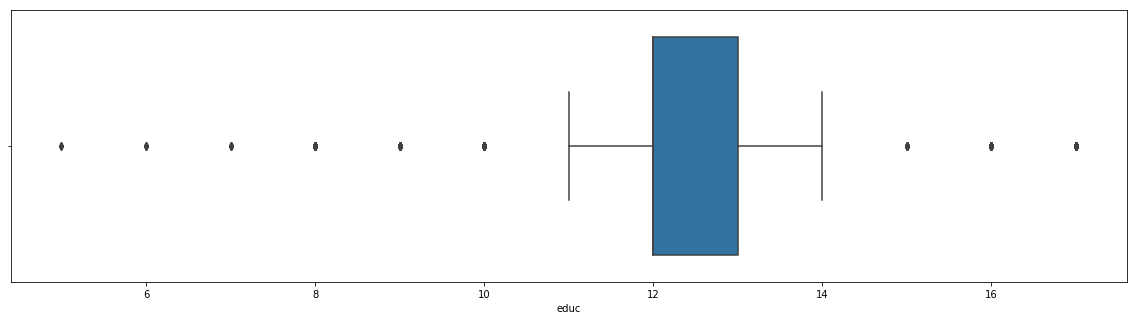

In [10]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x=data_B1['educ'])
plt.show()

Above plot shows  points above 14 and  below 11, these are outliers as there are not included in the box of other observations. We will use the IQR method to retrieve the outliers and remove them from our data.

We will use the Z-Score method to identify and remove outliers.

In [11]:
data_outliers=data_B1.copy()
data_B2=data_outliers[(np.abs(stats.zscore(data_outliers)) < 3).all(axis=1)]
print("We removed {} lines of data".format(len(data_B1)-len(data_B2)))

We removed 104 lines of data


### 3) Study Feature Multicolinearity:

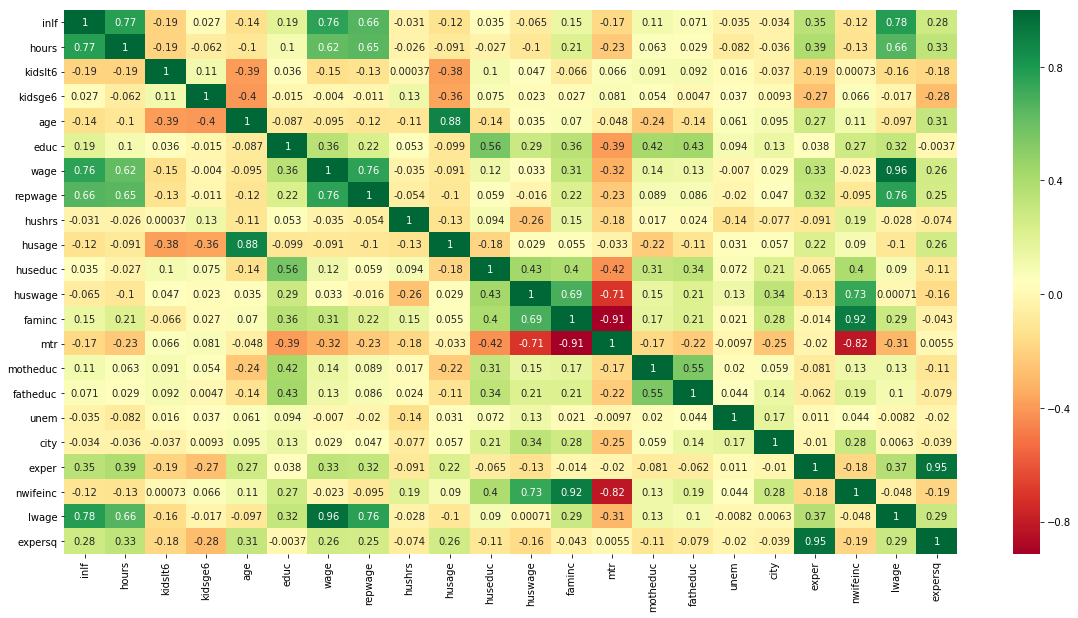

Positive correlation: 
 inlf     inlf        1.000000
         hours       0.769492
         wage        0.759624
         lwage       0.776173
age      husage      0.881161
wage     repwage     0.755144
         lwage       0.964823
repwage  lwage       0.761975
faminc   nwifeinc    0.915989
exper    expersq     0.950416
dtype: float64

 Negative correlation: 
 faminc  mtr        -0.912584
mtr     nwifeinc   -0.821806
dtype: float64


In [12]:
#lET'S FIRST Check if there is any correlation between the variables:
cor=data_B2.corr()
plt.subplots(figsize=(20, 10))
sns.heatmap(cor, annot=True, cmap="RdYlGn")
plt.show()

s = cor.unstack()
print("Positive correlation: \n", s[s.values>0.75].drop_duplicates())
print("\n Negative correlation: \n", s[s.values<-0.75].drop_duplicates())

Variables with strong correlation: 
- inlf and wage and hours
- age and husage
- lwage and wage
- exper and expersq
- faminc and nwifeinc
- mtr and faminc
- mtr and nwifeinc

If two variables are highly correlated (positively or negatively), they supply redundant information. Removing highly correlated predictors from the model is a critical step in modeling. For example:
* We can drop __lwage__ and __expersq__  since lwag is just the log of the wage and expersq is exper squared. 

* Variables like __hours__ and __wage__ are highly correlated to __infl__ because values only are higher than 0 for women who were in the labor force in 1975. Therefore we will drop them too.

* __mtr__, __faminc__ and __nwifeinc__  are highly correlated with eachother. Since __nwifeinc__ is defined using __faminc__ and __hours__, we will drop it because it doesn't add new information. 

* __age__ and __husage__ are highly correlated but we will so we will remove husage because it seems irrelevant for predicting our variable. 

In [13]:
data_B3=data_B2.drop(["lwage","expersq","hours","wage","nwifeinc","husage"],axis=1)
data_B3.describe()
selected_features=data_B3.drop('inlf',axis=1).columns.values
print(selected_features)

['kidslt6' 'kidsge6' 'age' 'educ' 'repwage' 'hushrs' 'huseduc' 'huswage'
 'faminc' 'mtr' 'motheduc' 'fatheduc' 'unem' 'city' 'exper']


## III. Build model

In [45]:
#Run model
def run_LogisticReg(data_tomodel,col,var_to_predict):
    X = data_tomodel[col]
    y = data_tomodel[var_to_predict]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)
    reg = LogisticRegression() 

    # train the model using the training sets 
    reg.fit(X_train, y_train) 
    # making predictions on the testing set 
    y_pred = reg.predict(X_test) 

    return y_pred,y_test,reg

#Evaluate model and accuracy:
def model_accuracy(y_pred,y_test,reg):
    
    print("\033[1m Classifiction report: \033[0m \n")
    print(classification_report(y_test,y_pred))

    print("\033[1m Confusion Matrix :  \033[0m \n")
    cm=confusion_matrix(y_test, y_pred)
    TP=cm[0][0]
    TN=cm[1][1]
    FP=cm[0][1]
    FN=cm[1][0]

    print("True positive: ", TP)
    print("True negative: ",TN)
    print("False positive: ", FP)
    print("False negative: ",FN)

    total=TP+TN+FP+FN
    Accuracy = (TP+TN)/total
    Error_Rate = (FP+FN)/total
    
    print("\n")
    
    print("\033[1m Logistic Regression model accuracy: \033[0m {} %".format(round(Accuracy*100,2)))
    print("\033[1m Error Rate: \033[0m",Error_Rate)


### III . Run model on data with selected features

#### Manually selected features:
First let's run the model with the manually selected features

In [46]:
y_pred,y_test,reg =run_LogisticReg(data_B3,selected_features,'inlf')   
print(pd.DataFrame({"Coef": reg.coef_[0,:].tolist()},index=data_B3.drop('inlf',axis=1).columns.tolist()))

model_accuracy(y_pred,y_test,reg)

              Coef
kidslt6  -0.103374
kidsge6   0.078128
age      -0.046676
educ      0.160720
repwage   1.072819
hushrs   -0.000707
huseduc   0.007702
huswage  -0.191891
faminc    0.000078
mtr      -0.000426
motheduc -0.010906
fatheduc  0.003868
unem     -0.007162
city     -0.026784
exper     0.052605
 Classifiction report:  

             precision    recall  f1-score   support

          0       0.80      0.91      0.85        97
          1       0.91      0.81      0.86       118

avg / total       0.86      0.86      0.86       215

 Confusion Matrix :   

True positive:  88
True negative:  96
False positive:  9
False negative:  22


 Logistic Regression model accuracy:  85.58 %
 Error Rate:  0.144186046512


#### Features selected using Recursive feature elimination process
Now let's run the model with features selected with a Recursive feature elimination method: 

Recursive feature elimination (RFE) refers to the process of selecting the optimal set of features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [55]:
def rfe_logisticR(data_temp,nb):    
    X=data_temp.drop('inlf',axis=1)
    y = data_temp['inlf']

    model = LogisticRegression()

    rfe = RFE(model,nb)
    rfe = rfe.fit(X, y)
    selected_features=list(X.columns[rfe.support_])

    Xf=X[selected_features]
    Xf_train, Xf_test, y_train, y_test = train_test_split(Xf, y,test_size=0.33)

    model.fit(Xf_train, y_train) 
    yf_pred = model.predict(Xf_test) 
    return selected_features, yf_pred,y_test,model


selected_features, yf_pred,y_test,reg = rfe_logisticR(data_B3,11)

print(pd.DataFrame({"Coef": reg.coef_[0,:].tolist()},index=selected_features))

model_accuracy(yf_pred,y_test,reg)

              Coef
kidslt6  -1.108732
kidsge6  -0.040850
age      -0.068335
educ      0.172474
repwage   1.466511
huswage   0.014821
mtr      -0.735508
motheduc  0.036595
unem     -0.085772
city     -0.127552
exper     0.083692
 Classifiction report:  

             precision    recall  f1-score   support

          0       0.79      0.92      0.85        93
          1       0.93      0.81      0.87       122

avg / total       0.87      0.86      0.86       215

 Confusion Matrix :   

True positive:  86
True negative:  99
False positive:  7
False negative:  23


 Logistic Regression model accuracy:  86.05 %
 Error Rate:  0.139534883721


By selecting the following features:['kidslt6', 'kidsge6', 'age', 'educ', 'repwage', 'huseduc', 'huswage', 'mtr', 'motheduc', 'unem', 'city', 'exper'], we have increased the model accuracy. 